In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tqdm import tqdm

In [2]:
DATADIR = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\data_distribution\data_distribution8-30\train"
CATEGORIES = ['0', '1','2','3','4','5','6','7','8','9']
IMG_SIZE=50

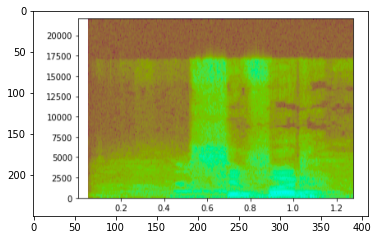

In [3]:
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        break
    break

In [4]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data() 

In [5]:
print(len(training_data))

930


In [6]:
lenofimage = len(training_data)

In [7]:
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,-1)
##X = tf.keras.utils.normalize(X, axis = 1)

In [8]:
X.shape

(930, 7500)

In [9]:
X = X/255.0

In [10]:
X[1]

array([1., 1., 1., ..., 1., 1., 1.])

In [11]:
y=np.array(y)

In [12]:
y.shape

(930,)

In [13]:
SEED = 42
from sklearn.model_selection import train_test_split
import random
random.seed(SEED)
# partition the data into 80% training and 20% validation
(trainX, testX, trainY, testY) = train_test_split(X,y, test_size=0.3, random_state=SEED)

In [14]:
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))
import warnings
warnings.filterwarnings("ignore")
from keras.optimizers import SGD

In [15]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
testY = lb.transform(testY)         # transform = perform the one-hot encoding (unique class labels already found)

In [16]:
testY

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [17]:
#Initialising ANN
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense

model = Sequential()   # input layer 7500 as there are 32x32x3=3072 pixels in a flattened input image
model.add(Dense(1024, input_shape=(7500,), activation="relu"))# first hidden layer has 1024 nodes
model.add(Dense(512, activation="relu"))                         # second hidden layer has 512 nodes
model.add(Dense(len(CATEGORIES), activation="softmax"))            # output layer with number of possible class labels

In [18]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-08, decay=0.01)
import keras.backend as K
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
                   specificity,conditional_average_metric ,sensitivity,F1_Score,'accuracy']

In [19]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 60
 
# compile the model using SGD as our optimizer and categorical cross-entropy loss
# (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)   # Stochastic Gradient Descent (SGD) optimizer
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics)

[INFO] training network...


In [20]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

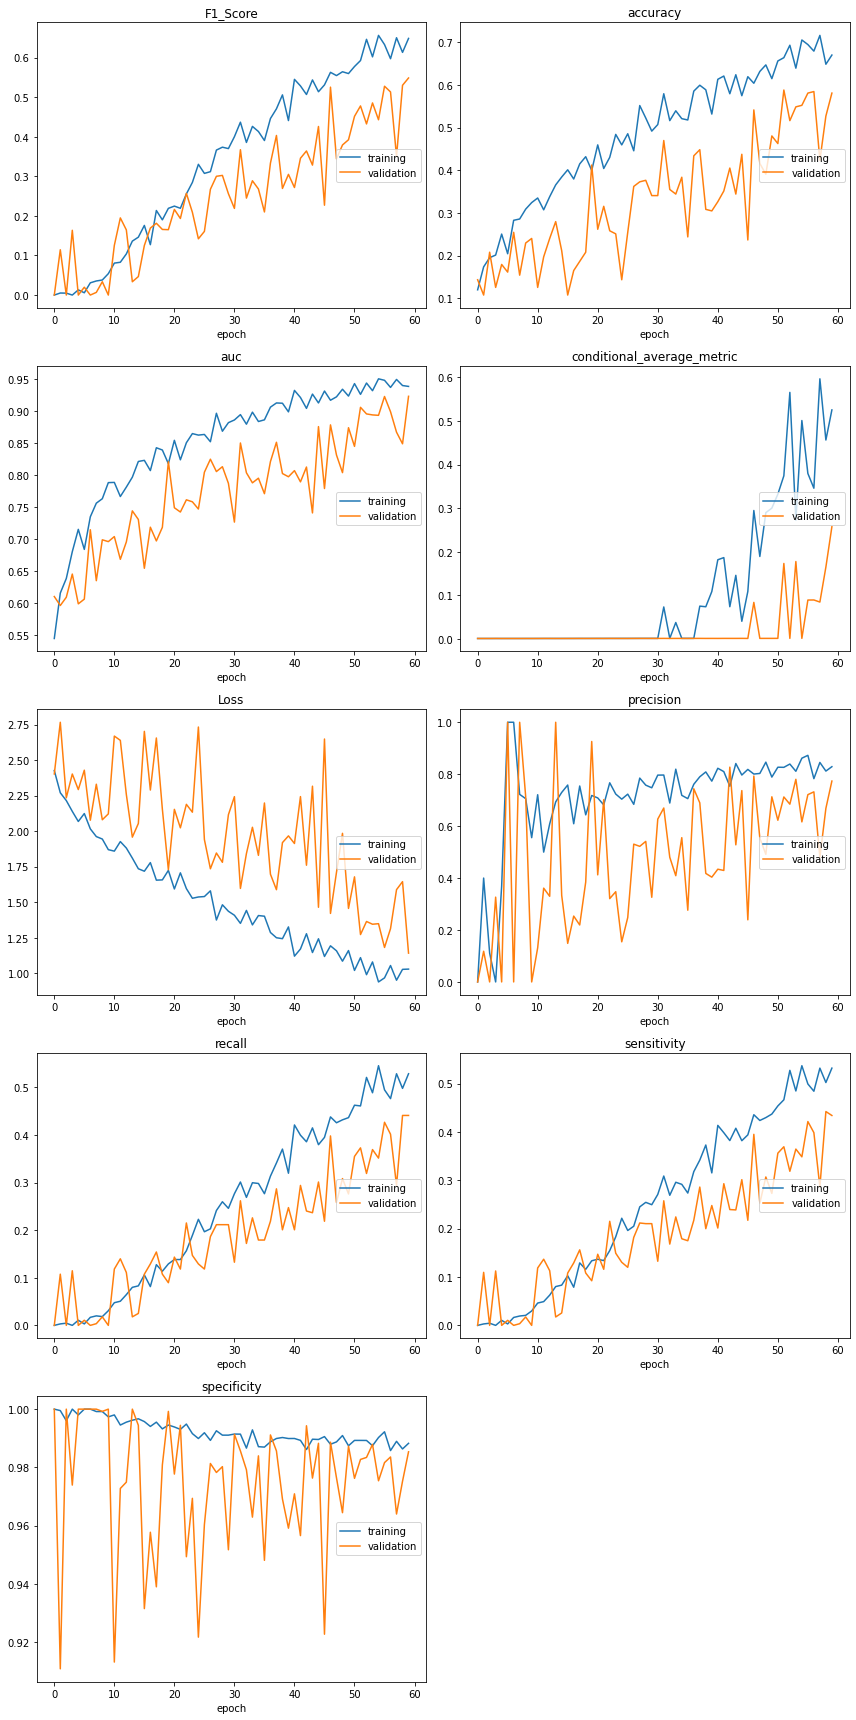

F1_Score
	training         	 (min:    0.000, max:    0.656, cur:    0.649)
	validation       	 (min:    0.000, max:    0.549, cur:    0.549)
accuracy
	training         	 (min:    0.120, max:    0.716, cur:    0.670)
	validation       	 (min:    0.108, max:    0.588, cur:    0.581)
auc
	training         	 (min:    0.544, max:    0.951, cur:    0.939)
	validation       	 (min:    0.596, max:    0.923, cur:    0.923)
conditional_average_metric
	training         	 (min:    0.001, max:    0.597, cur:    0.525)
	validation       	 (min:    0.001, max:    0.257, cur:    0.257)
Loss
	training         	 (min:    0.940, max:    2.426, cur:    1.030)
	validation       	 (min:    1.142, max:    2.766, cur:    1.142)
precision
	training         	 (min:    0.000, max:    1.000, cur:    0.829)
	validation       	 (min:    0.000, max:    1.000, cur:    0.774)
recall
	training         	 (min:    0.000, max:    0.545, cur:    0.528)
	validation       	 (min:    0.000, max:    0.441, cur:    0.441)
sensi

In [21]:
# train the neural network on training data set
# batch_size (32) controls the size of each group of data to pass through the network. 
# Larger GPUs would be able to accommodate larger batch sizes (eg. 64)
time1 = time.time()   # to measure time taken
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32,callbacks = [plot_loss_1])
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken

In [22]:
y2 = model.predict(testX)
print(y2)

9/9 [==============================] - 0s 14ms/step
[[0.18466325 0.01920089 0.01138575 ... 0.39913365 0.30495492 0.00363914]
 [0.00128581 0.00547816 0.04538064 ... 0.00981998 0.08945493 0.02350226]
 [0.77435875 0.007565   0.05837008 ... 0.04436743 0.03613975 0.00135051]
 ...
 [0.08483449 0.09844238 0.08660169 ... 0.0070974  0.01708651 0.00595632]
 [0.08483449 0.09844238 0.08660169 ... 0.0070974  0.01708651 0.00595632]
 [0.16179709 0.35072035 0.04019821 ... 0.03303916 0.2785789  0.00630349]]


In [23]:
# evaluate the network
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=CATEGORIES))

[INFO] evaluating network...
9/9 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        34
           1       0.87      0.67      0.75        30
           2       0.74      0.88      0.80        32
           3       0.42      0.63      0.51        30
           4       1.00      0.33      0.50        30
           5       1.00      0.03      0.07        29
           6       0.55      0.87      0.67        31
           7       0.94      0.71      0.81        24
           8       0.19      0.92      0.31        12
           9       1.00      0.11      0.20        27

    accuracy                           0.58       279
   macro avg       0.75      0.59      0.54       279
weighted avg       0.78      0.58      0.56       279



In [24]:
y_pred=np.argmax(y2, axis=1)
y_test=np.argmax(testY, axis=1)

<AxesSubplot:>

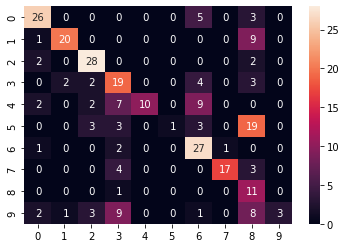

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='2.0f')